## GEO 1001 - Assignment 02
Classification of a Sentinel-2 image

###### Ondrej Veselý, 5162130
###### Carolin Bachert, 5382998


### Introduction
The aim of this assignment is to implement a program in Python that classifies a Sentinel-2 image based on a selection of different bands. The satellite image is from the area around Delft, taken on the 30th of May 2020. It is available in three different resolutions (60m, 20m, 10m), of which we focus on the lowest resolution one in the full extent and the highest resolution one as a subset of the whole image.

Since there is no ground truth available, we implement an unsupervised classification mainly with [Mini Batch K-Means](https://scikit-learn.org/stable/modules/clustering.html#mini-batch-k-means), which is a variant of the k-means classification algorithm. The advantage lies in the faster computation time with a just slightly reduced quality of the output.

With the implementation, we aim to classify different land covers based on their specific spectral signature throughout the electromagnetic spectrum. From the idea, we want to create something similar to the Corine Land Cover, although just in a much smaller and simpler scope.


In [1]:
# import required modules
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import rasterio
from sklearn.cluster import *

In [2]:
# import the data
path = './GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/'

import os
from collections import OrderedDict

def load_jp2(path):
  d = OrderedDict()
  for file in os.listdir(path):
    if file.endswith('.jp2'):
      band = file.split('_')[2]
      full_path = path + file
      d[band] = rasterio.open(full_path)
      
  return d      

r60m = load_jp2(path + '/R60m/')
r20m = load_jp2(path + '/R20m/')
r10m = load_jp2(path + '/R10m/')

## First visual check

With the data and required modules imported, as a first step we plot all the bands of the r60m dataset to test if everything is working properly and to have a first visual representation of our data. 

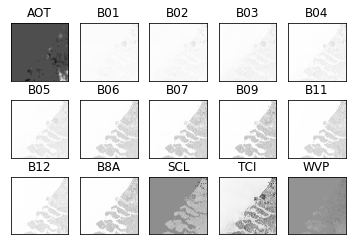

In [5]:
for i, (band, data) in enumerate(r60m.items()):
  ax = plt.subplot2grid((3,5), (i//5, i%5))
  ax.imshow(data.read()[0], cmap='binary')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_title(band)

plt.show()

## RGB plot
In order to have a more 'human-readable' representation of the dataset and a reference for evaluation of the classified images we create a pseudo-true colour raster image by combining the red, green and blue band.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


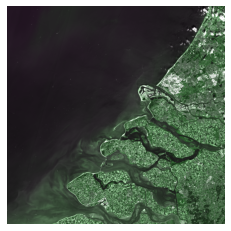

In [6]:
# pseudo rgb
bands = ['B02', 'B03', 'B02']
dataset = r60m

data = [dataset[band] for band in bands if band in dataset]
stack = np.array([img.read()[0].flatten()/2000 for img in data]).T
rgb_arr = np.array(np.split(stack, data[0].width))

plt.axis('off')
plt.imshow(rgb_arr)

## First try at k-means
For start, lets try setting up simple k-means classifier between two bands, red and blue, and see how far it can get us.

Label 0: 2596958 occurences
Label 1: 671554 occurences
Label 2: 80388 occurences


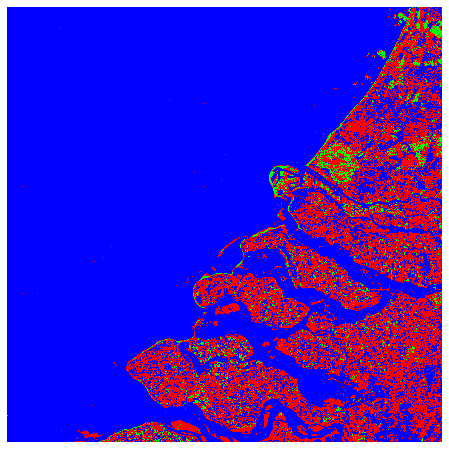

In [7]:
# parameters
bands = ['B02', 'B04']
dataset = r60m
n_labels = 3
seed = 1


data = [dataset[band] for band in bands]
stack = np.array([img.read()[0].flatten() for img in data]).T
kmeans = MiniBatchKMeans(n_clusters=n_labels, random_state=seed).fit(stack)
label_arr = np.array(np.split(kmeans.labels_, data[0].width))

for i in range(n_labels):
  print('Label %s: %s occurences' % (i, np.count_nonzero(kmeans.labels_ == i)))

plt.figure(figsize = (8,8))
plt.axis('off')
plt.imshow(label_arr, cmap='brg', interpolation='nearest')

With only two variables as an input, we start slow with setting number of k-means cluster to 3. From comparison of previous RGB raster and the resulting classification, we can deduce the following;
- Label 0 *(Blue in 'brg' cmap)*: **2596958 occurences**, probably water and other low-albedo surfaces
- Label 1 *(Red in 'brg' cmap)*: **671554 occurences**, generic landcover
- Label 2 *(Green in 'brg' cmap)*: **80388 occurences**, e.g. greenhouses, clouds and other high-albedo surfaces

Let's take a better look at how the classes look in a scatter plot.

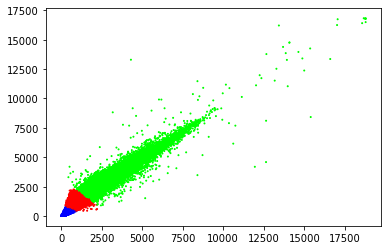

In [8]:
plt.scatter(stack.T[0], stack.T[1], c=kmeans.labels_, cmap='brg', s=1, alpha=1)

From the scatterplot, we can fairly easily observe several things;

- Bands **B02** and **B04** are highly correlated, judging from the linear appearance of the plot.
- Most of the values are ranging in between **0 to 10000** on the 16-bit uint range.
- Knowing that the most occurent Label is Label 0 (displayed as **blue** here) and the second most after that Label 1 (**red**), we know that the lower left corner of the scatterplot is much more densily populated than it's obivous from the image.

Let's zoom in onto the lower left corner of the plot to see if we can observe some clustering that k-means hasn't registered in there.

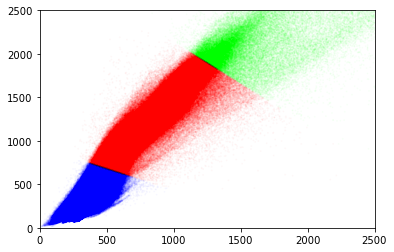

In [9]:
plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.scatter(stack.T[0], stack.T[1], c=kmeans.labels_, cmap='brg', s=1, alpha=0.02)


But the zoom only confirms what we thought before. The high correlation of the bands results in k-means classifying the datapoints based almost only their total reflectivity.

In order to improve the result, we have to more carafully choose the bands on which the classification is based. 
Bands which have a high correlation coefficient, show a high level of data redundancy. Hence, comparing such bands *(as in example above)*, doesn't usually lead to very meaningful results.

Let's first plot a corellation matrix (here Pearson correlation is used) for all bands of the r60m dataset,
and try to identify the most applicable bands for classifications.

In [8]:
data = r60m

matrix = []
for a in data.values():
  row = []
  for b in data.values():
    pears = stats.pearsonr(a.read()[0].flatten(), b.read()[0].flatten())[0]
    pears = round(ndigits=2, number=pears)
    row.append(pears)
    
  matrix.append(row)

pd.DataFrame(matrix, columns=data.keys(), index=data.keys())

,AOT,B01,B02,B03,B04,B05,B06,B07,B09,B11,B12,B8A,SCL,TCI,WVP
AOT,1.00,0.05,0.06,0.05,0.04,0.01,-0.03,-0.04,-0.04,-0.05,-0.02,-0.05,0.10,0.04,0.12
B01,0.05,1.00,0.95,0.88,0.85,0.75,0.47,0.40,0.42,0.57,0.64,0.38,0.05,0.76,-0.12
B02,0.06,0.95,1.00,0.96,0.93,0.82,0.53,0.46,0.47,0.65,0.72,0.44,-0.02,0.85,-0.15
B03,0.05,0.88,0.96,1.00,0.98,0.93,0.71,0.65,0.65,0.80,0.84,0.63,-0.24,0.93,-0.13
B04,0.04,0.85,0.93,0.98,1.00,0.95,0.71,0.64,0.64,0.85,0.90,0.63,-0.27,0.97,-0.19
B05,0.01,0.75,0.82,0.93,0.95,1.00,0.88,0.83,0.83,0.95,0.94,0.82,-0.49,0.94,-0.11
B06,-0.03,0.47,0.53,0.71,0.71,0.88,1.00,0.99,0.99,0.92,0.82,0.99,-0.72,0.72,0.09
B07,-0.04,0.40,0.46,0.65,0.64,0.83,0.99,1.00,0.99,0.89,0.77,1.00,-0.75,0.66,0.13
B09,-0.04,0.42,0.47,0.65,0.64,0.83,0.99,0.99,1.00,0.89,0.77,0.99,-0.73,0.65,0.11
B11,-0.05,0.57,0.65,0.80,0.85,0.95,0.92,0.89,0.89,1.00,0.97,0.89,-0.64,0.87,-0.14


## Second try

Based on the correlation matrix we selected a group of bands, ommiting the ones redundant to the rest of the set based on their correlation. It should be noted that we did this by hand.

Selected bends are;
- AOT
- B01
- B03
- B05
- B09
- B11
- SCL
- TCI
- WVP

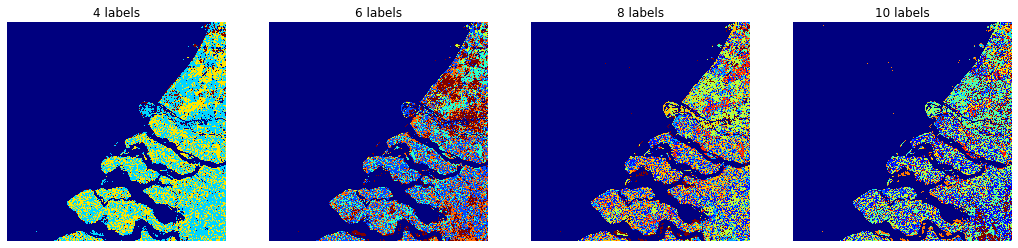

In [13]:
bands = ['AOT', 'B01', 'B03', 'B05', 'B09', 'B11', 'SCL', 'TCI', 'WVP']
dataset = r60m
n_labels = [4, 6, 8, 10]
seed = 2

plt.figure(figsize=(18,8))

for i, n in enumerate(n_labels):
    data = [dataset[band] for band in bands if band in dataset]
    stack = np.array([img.read()[0].flatten() for img in data]).T
    kmeans = MiniBatchKMeans(n_clusters=n_labels[i], random_state=seed).fit(stack)
    label_arr = np.array(np.split(kmeans.labels_, data[0].width))

    ax = plt.subplot2grid((1, len(n_labels)), (0, i))
    ax.imshow(label_arr, cmap='jet', interpolation='nearest')
    ax.axis('off')
    ax.set_title('%s labels' % n)
    
plt.show()

## Selected parameters

The second classification attempt yields much more defined results than the first one. After trying out different parameters we settled on using 6 classes as a best number of classification of our dataset with k-means algorithm. We chose 6 classes in order to be able to depict different land uses, but to not create too much noise. 

By that, we can clearly observe the urban areas and industrial zones in the delta around Rotterdam. In agricultural areas, we can observe parcelation of the use of land.

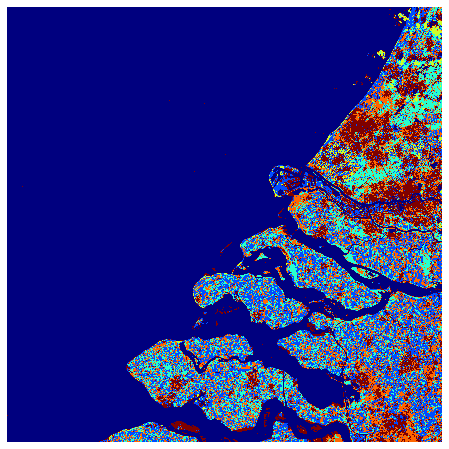

In [15]:
# parameters
bands = ['AOT', 'B01', 'B03', 'B05', 'B09', 'B11', 'SCL', 'TCI', 'WVP']
dataset = r60m
n_labels = 6
seed = 2


data = [dataset[band] for band in bands if band in dataset]
stack = np.array([img.read()[0].flatten() for img in data]).T
kmeans = MiniBatchKMeans(n_clusters=n_labels, random_state=seed).fit(stack)
label_arr = np.array(np.split(kmeans.labels_, data[0].width))

plt.figure(figsize = (8,8))
plt.axis('off')
plt.imshow(label_arr, cmap='jet', interpolation='nearest')

On closer observation, it's clear that classification isn't perfect, some of the labels overlap, e.g. industrial areas of Rotterdam port and some of fields to the south get clustered together.

Let's try whether we can improve the result by saturating the k-means model with all bands we have available.


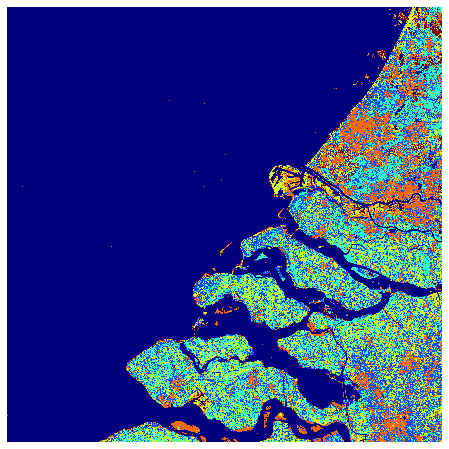

In [23]:
# parameters
bands = r60m.keys()
dataset = r60m
n_labels = 6
seed = 2


data = [dataset[band] for band in bands if band in dataset]
stack = np.array([img.read()[0].flatten() for img in data]).T
kmeans = MiniBatchKMeans(n_clusters=n_labels, random_state=seed).fit(stack)
label_arr = np.array(np.split(kmeans.labels_, data[0].width))

plt.figure(figsize = (8,8))
plt.axis('off')
plt.imshow(label_arr, cmap='jet', interpolation='nearest')

We tried to improve the results by increasing the dimensionality of the k-means search space and include all of the bands of the r60m dataset.

The resulting classification doesn't seem to improve compared to the previous one (see in detail in Fig 1 and 2 below).

We even speculate that more noise was introduced in the agricultural land between Delft and Rotterdam, but any comparisions on the occuracy of the two classifications are hard to make without the ground-truth data and a more systematic aproach to measuring their properties.

![img](https://github.com/ondrej-vesely/GEO1001-hw2/blob/master/img/selected_bands.png?raw=true)
###### Fig. 1: K-means classifier for 6 classes using preselected bands based on their correlation.

![img](https://github.com/ondrej-vesely/GEO1001-hw2/blob/master/img/all_bands.png?raw=true)
###### Fig. 2: K-means classifier for 6 classes using all available bands.



We were unable to improve the results further using k-means classification.
We decided to move on to the next dataset and leave the exploration of different algorithms for later.


## High resolution dataset

In the second part of the exercise, we are going to apply the previous methods to the higher resolution dataset of EM bands collected in the same area.

Since the increased resolution of the data makes the computation more costly, we will only process a subset of the whole area.

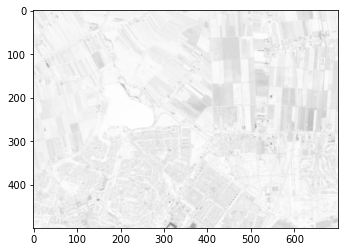

In [24]:
# location of subset
subset = (601200.0, 5773695.0, 700, 500)

def crop(ds, x, y, row, col):
  row_off,col_off = ds.index(x,y)
  window = rasterio.windows.Window(col_off, row_off, row, col)
  return ds.read(window=window).astype('float')[0]
     
plt.imshow(
  crop(r10m['B04'], *subset), cmap='binary')

The high-res dataset doesn't include all the bands of the previous dataset.
To repeat our previous method, we are going to take a look at the correlation matrix again.

In [25]:
data = r10m

matrix = []
for a in data.values():
  row = []
  for b in data.values():
    pears = stats.pearsonr(crop(a, *subset).flatten(), crop(b, *subset).flatten())[0]
    pears = round(ndigits=2, number=pears)
    row.append(pears)
    
  matrix.append(row)

pd.DataFrame(matrix, columns=data.keys(), index=data.keys())

,AOT,B02,B03,B04,B08,TCI,WVP
AOT,1.00,0.08,0.00,0.05,-0.26,0.05,-0.06
B02,0.08,1.00,0.94,0.95,-0.24,0.93,-0.23
B03,0.00,0.94,1.00,0.95,0.01,0.92,-0.15
B04,0.05,0.95,0.95,1.00,-0.22,0.99,-0.26
B08,-0.26,-0.24,0.01,-0.22,1.00,-0.23,0.47
TCI,0.05,0.93,0.92,0.99,-0.23,1.00,-0.27
WVP,-0.06,-0.23,-0.15,-0.26,0.47,-0.27,1.00


Based on the correlation matrix we selected a group of bands, ommiting the ones redundant to the rest of the set based on their correlation. It should be noted that we did this by hand.

Selected bends were;
- AOT
- B03
- B08
- TCI
- WVP

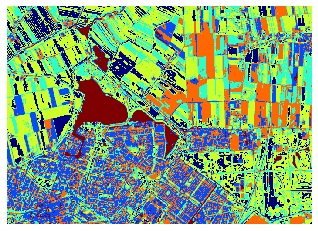

In [26]:
# parameters
bands = ['AOT', 'B03', 'B08', 'TCI', 'WVP']
dataset = r10m
subset = (601200.0, 5773695.0, 700, 500)
n_labels = 6
seed = 1


data = [dataset[band] for band in bands if band in dataset]
stack = np.array([crop(img, *subset).flatten() for img in data]).T
kmeans = MiniBatchKMeans(n_clusters=n_labels, random_state=seed).fit(stack)
label_arr = np.array(np.split(kmeans.labels_, subset[3]))

plt.axis('off')
plt.imshow(label_arr, cmap='jet', interpolation='nearest')

## NVDI Hypothesis

We can visually differentiate between the urban structure, water, and agricultural land, but the labels used for the build-up areas are used for lot of the agricultural fields as well.

We hypothesize, whether the results could be improved by introducing NVDI as one of the extra bands.

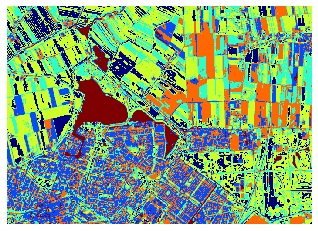

In [27]:
basic_bands = ['AOT', 'B03', 'B08', 'TCI', 'WVP']

red = crop(r10m['B04'], *subset).flatten()
nir = crop(r10m['B08'], *subset).flatten()
nvdi = (nir - red) / (nir + red)

basic_bands = [crop(r10m[band], *subset).flatten() for band in basic_bands]
aug_bands = basic_bands + [nvdi]

stack = np.array(aug_bands).T
kmeans = MiniBatchKMeans(n_clusters=n_labels, random_state=seed).fit(stack)
label_arr = np.array(np.split(kmeans.labels_, subset[3]))

plt.axis('off')
plt.imshow(label_arr, cmap='jet', interpolation='nearest')
                           

Seems like the addition of the NVDI had no noticable impact on the results.
It could be because augumenting k-means model with data derived from the data already included, has little impact on the results. 
Also NVDI between urban areas and agricultural field seems to have very similar values in this specific data subset (see below).

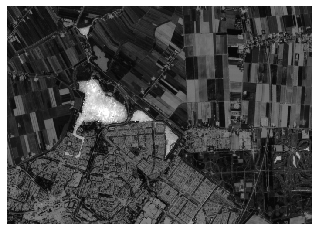

In [28]:
nvdi_arr = np.array(np.split(nvdi, subset[3]))
plt.axis('off')
plt.imshow(nvdi_arr, cmap='binary', interpolation='nearest')

## Resolution comparison
As a last exercise we decided out of curiosty to compare the results from higher resolution dataset with the results derived from the lower resolutions datasets.


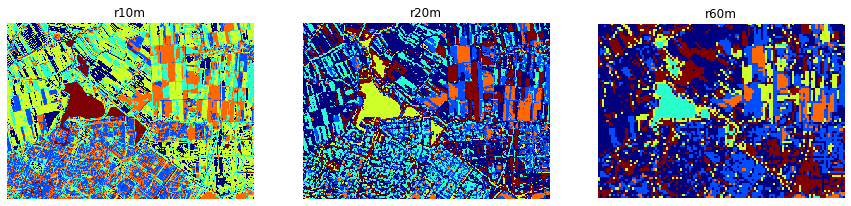

In [29]:
bands = ['AOT', 'B03', 'B08', 'TCI', 'WVP']
datasets = (r10m, r20m, r60m)
subsets = ((601200.0, 5773695.0, 700, 500), 
           (601200.0, 5773695.0, 350, 250),
           (601200.0, 5773695.0, 117, 83))
n_labels = 6
seed = 1

plt.figure(figsize=(15,5))
for i, (dataset, subset) in enumerate(zip(datasets, subsets)):
  data = [dataset[band] for band in bands if band in dataset]
  stack = np.array([crop(img, *subset).flatten() for img in data]).T
  kmeans = MiniBatchKMeans(n_clusters=n_labels, random_state=seed).fit(stack)
  label_arr = np.array(np.split(kmeans.labels_, subset[3]))
  
  ax = plt.subplot2grid((1, len(datasets)), (0, i))
  ax.imshow(label_arr, cmap='jet', interpolation='nearest')
  ax.set_title(['r10m', 'r20m', 'r60m'][i])
  ax.axis('off')
  
plt.show()

Comparing the k-means classifiers with same parameters with different resolutions as inputs, we can still state that the classifier based on the highest resolution dataset performs the best.

The urban area in the lower resolution is basically indescernable from the rest in the r60m set. In the r20m set it is still very similar to the agricultural land in terms of classification.

Depending on the size of the area we are interested in, it is therefore worth the higher costs of using a higher resolution. When working with a bigger area, the higher computation time needs to be taken into account as well as the possibility, that small differences get lost due to the scale.


## Third time's the charm with DBSCAN?

As an experiment we tried also applying DBSCAN algorithm as a classifier. However trying different EPS (maximal distance between datapoints to be clustered) the best we got the algorithm to perform was to be to classify the water bodies, which were already cleary identifiable in the k-means classifications.

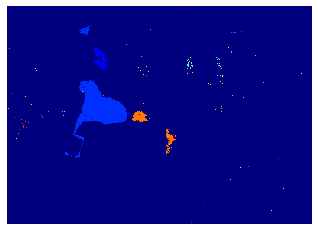

In [30]:
# DBSCAN parameters
bands = r10m.keys()
dataset = r10m
subset = (601200.0, 5773695.0, 700, 500)
EPS = 15

stack = np.array([crop(dataset[band], *subset).flatten() 
                  for band in bands]).T
dbscan = DBSCAN(eps=EPS).fit(stack)
label_arr = np.array(np.split(dbscan.labels_, subset[3]))

plt.axis('off')
plt.imshow(label_arr, cmap='jet', interpolation='nearest')

## BONUS ROUND - Alternative clustering algos

Below you can find an assortment of alternative unsupervised clustering algorithms.
Since most of them have a high computation cost for large datasets, we apply them to a computationally lighter snippet from r60m dataset instead.

- [Ward Hiearchical clustering;](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
    Probably the best result we've seen in the subset area, and that was just using the r60m dataset. You can differentiate between classes for water, urban structures and different levels for vegetation.

- [Birch Clustering Feature Tree;](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html#sklearn.cluster.Birch)
    Exactly the same result as with the Ward Aglomerative clustering. Probably very similar implementations. Alhough we haven't done our research onto how the two implementations work similary, we are happy with the results.
    
- [OPTICS;](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html#sklearn.cluster.OPTICS)
    We weren't able to get satisfying results for out dataset using OPTICS clustering algorithm. It needs to be said that the this algorithm uses fair amount of parameters that need to be tailored to your specific case and thanks to a rather large amount of computation time per iteration, we haven't dived very deep into those.

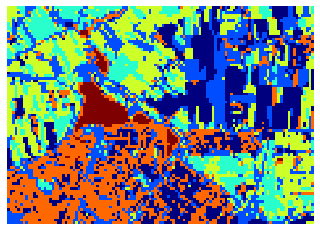

In [31]:
# Ward hiearchical
bands = r60m.keys()
dataset = r60m
subset = (601200.0, 5773695.0, 117, 83)
n_labels = 6

data = [dataset[band] for band in bands if band in dataset]
stack = np.array([crop(img, *subset).flatten() for img in data]).T
clustering = AgglomerativeClustering(n_clusters=n_labels).fit(stack)
label_arr = np.array(np.split(clustering.labels_, subset[3]))

plt.axis('off')
plt.imshow(label_arr, cmap='jet', interpolation='nearest')

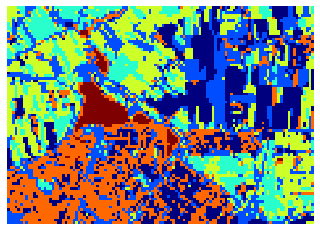

In [32]:
# Birch
bands = r60m.keys()
dataset = r60m
subset = (601200.0, 5773695.0, 117, 83)
n_labels = 6
threshold = 0.5

data = [dataset[band] for band in bands if band in dataset]
stack = np.array([crop(img, *subset).flatten() for img in data]).T
clustering = Birch(n_clusters=n_labels,
                  threshold=threshold).fit(stack)
label_arr = np.array(np.split(clustering.labels_, subset[3]))

plt.axis('off')
plt.imshow(label_arr, cmap='jet', interpolation='nearest')

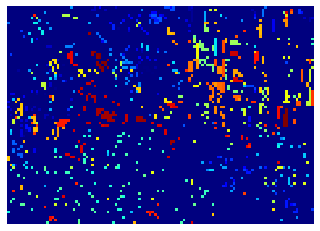

In [33]:
# OPTICS
bands = r60m.keys()
dataset = r60m
subset = (601200.0, 5773695.0, 117, 83)
min_samples = 2
max_eps = 2

data = [dataset[band] for band in bands if band in dataset]
stack = np.array([crop(img, *subset).flatten() for img in data]).T
clustering = OPTICS().fit(stack)
label_arr = np.array(np.split(clustering.labels_, subset[3]))

plt.axis('off')
plt.imshow(label_arr, cmap='jet', interpolation='nearest')

## Conclusion
Pros and Cons of our method.
Does it work good or are the results not good, why could they be not good? (are the results good according to us, if not, why?)



As a lookout: Maybe think about other classification algorithms that are better fitted to the task. Or think about a ground truth we could take into consideration to improve results (for example the corine or landcover dataset?)



###### Ondrej Veselý & Carolin Bachert, 2020